In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt




In [2]:
# Load the uploaded dataset to inspect its structure
data = pd.read_csv('traffic_weather.csv')

# Display the first few rows of the dataset to understand its structure
data.head()


,Intersection Name,Month,Day,Year,Hour,Day of Week,Holiday,Direction,Speed,Volume,Full Date,date,tavg,tmin,tmax,prcp,snow,wspd,temperature
0,Azie MortonBarton Springs,7,9,2019,1,2,0,NB,28.0,9.0,2019-07-09 01:00:00,7/9/19,29.5,23.9,36.1,0.0,0,7.2,23.900000
1,Azie MortonBarton Springs,7,9,2019,1,2,0,SB,24.0,8.0,2019-07-09 01:00:00,7/9/19,29.5,23.9,36.1,0.0,0,7.2,23.900000
2,Azie MortonBarton Springs,7,9,2019,0,2,0,NB,28.0,25.0,2019-07-09 00:00:00,7/9/19,29.5,23.9,36.1,0.0,0,7.2,23.900000
3,Azie MortonBarton Springs,7,9,2019,0,2,0,SB,28.0,36.0,2019-07-09 00:00:00,7/9/19,29.5,23.9,36.1,0.0,0,7.2,23.900000
4,Azie MortonBarton Springs,7,8,2019,23,1,0,NB,27.0,26.0,2019-07-08 23:00:00,7/8/19,28.1,22.2,36.1,9.7,0,6.1,33.227611


In [3]:
missing_values = data.isnull().sum()

volume_distribution = data['Volume'].describe()

missing_values, volume_distribution

(Intersection Name    0
 Month                0
 Day                  0
 Year                 0
 Hour                 0
 Day of Week          0
 Holiday              0
 Direction            0
 Speed                0
 Volume               0
 Full Date            0
 date                 0
 tavg                 0
 tmin                 0
 tmax                 0
 prcp                 0
 snow                 0
 wspd                 0
 temperature          0
 dtype: int64,
 count    566380.000000
 mean        597.239546
 std         486.829547
 min           0.000000
 25%         142.000000
 50%         517.000000
 75%         948.000000
 max        4813.000000
 Name: Volume, dtype: float64)

In [4]:
# Data Preprocessing
# Encode categorical variables

label_encoder = LabelEncoder()
data['Intersection Name'] = label_encoder.fit_transform(data['Intersection Name'])
data['Direction'] = label_encoder.fit_transform(data['Direction'])
data['Month'] = label_encoder.fit_transform(data['Month'])
data['Day'] = label_encoder.fit_transform(data['Day'])
data['Year'] = label_encoder.fit_transform(data['Year'])
data['Hour'] = label_encoder.fit_transform(data['Hour'])
# data['Day of Week'] = label_encoder.fit_transform(data['Day of Week'])

# Select predictors and target
features = [
    'Intersection Name', 'Month', 'Day', 'Year', 'Hour', 'Day of Week',
    'Holiday', 'Direction', 'Speed', 'prcp', 'snow', 'wspd', 'temperature'
]
X = data[features]
y = data['Volume']


In [5]:
scaler = StandardScaler()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate categorical features for CatBoost
categorical_features_min = ['Intersection Name', 'Direction']
# categorical_features_tot = ['Intersection Name', 'Direction', 'Day of Week', 'Holiday']

categorical_features_red = ['Intersection Name', 'Direction', 'Day of Week', 'Holiday', 'Month', 'Day', 'Year', 'Hour']

categorical_features = categorical_features_red

numeric_features = ['Speed', 'prcp', 'snow', 'wspd', 'temperature']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


# Output the shapes of the splits and confirm setup
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((453104, 13), (113276, 13), (453104,), (113276,))

In [6]:
y_train_log = np.log1p(y_train)

# Set up training data for CatBoost Pool
train_pool = Pool(X_train, y_train_log, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Example grid search
best_model = None
best_mse = float('inf')

for depth in [4, 6, 8]:
    for learning_rate in [0.01, 0.05, 0.1]:
        model = CatBoostRegressor(
            iterations=1000, 
            depth=depth, 
            learning_rate=learning_rate, 
            cat_features=categorical_features,
            verbose=0
        )
        model.fit(train_pool)
        y_pred_log = model.predict(test_pool)
        y_pred = np.expm1(y_pred_log)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        if mse < best_mse:
            best_depth = depth
            best_lr = learning_rate
            best_mse = mse
            best_model = model
            best_r2 = r2


Best model: <catboost.core.CatBoostRegressor object at 0x00000220C8E69BB0>
depth: 8, lr: 0.1
Best Model RMSE: 112.36383528172144
Best Model R squared: 0.9466517716177575


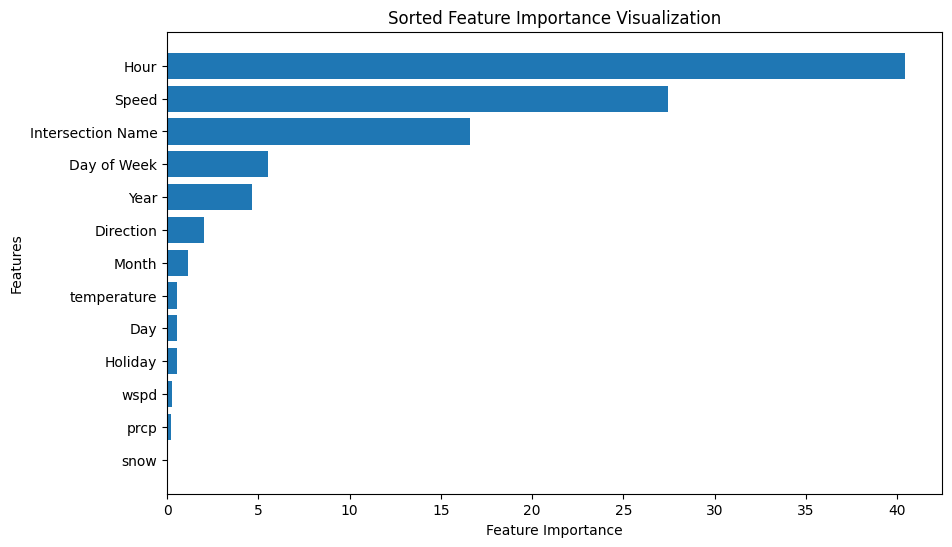

In [7]:
print(f"Best model: {best_model}")
print(f"depth: {best_depth}, lr: {best_lr}")
print(f"Best Model RMSE: {np.sqrt(best_mse)}")
print(f"Best Model R squared: {best_r2}")

feature_importances = best_model.get_feature_importance()
feature_names = best_model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Sorted Feature Importance Visualization')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

